<a href="https://colab.research.google.com/github/nsp8/Machine-Learning-Resources/blob/colab-ml-practice/regression_flood_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from google.colab import drive


#### Horizontal Chart for values associated with text labels

In [23]:
class Charts:
    def __init__(self, data, width=18, height=9, font_family="Sans Serif"):
        self.fig, self.ax = plt.subplots(figsize=(width, height))
        self.data = data
        self.y_pos = [i * 0.9 for i in range(len(data))]
        self.ax.barh(
            self.y_pos,
            self.data.values(),
            height=0.55,
            align="edge",
            color="blue",
        )
        self.font_family = font_family

    @property
    def max_data_value(self):
        return max(self.data.values())

    @property
    def min_data_value(self):
        return min(self.data.values())

    @property
    def axis_period(self):
        return int(self.max_data_value) // 10 or 1

    def set_axes(self):
        from math import ceil
        data_size = len(self.data)
        num_ticks = ceil(self.max_data_value)
        self.ax.xaxis.set_ticks([i * self.axis_period for i in range(num_ticks)])
        self.ax.xaxis.set_ticklabels(
            [i * self.axis_period for i in range(0, num_ticks)],
            size=16,
            fontfamily=self.font_family,
            fontweight=100,
        )
        self.ax.xaxis.set_tick_params(labelbottom=False, labeltop=True, length=0)
        self.ax.set_axisbelow(True)
        self.ax.grid(axis="x", color="#8C92AC", lw=1.2)
        self.ax.spines["left"].set_visible(False)
        self.ax.spines["right"].set_visible(False)
        self.ax.spines["top"].set_visible(False)
        self.ax.spines["bottom"].set_visible(False)
        self.ax.spines["left"].set_lw(1.5)
        self.ax.spines["left"].set_capstyle("butt")
        self.ax.yaxis.set_visible(False)
        return self

    def add_bar_text(self, label_object: dict):
        self.ax.text(
            x=label_object["x_pos"],
            y=label_object["y_pos"],
            s=label_object["text"],
            c=label_object["color"],
            fontfamily=self.font_family,
            fontsize=12,
            va="center",
            path_effects=label_object["path_effects"],
        )

    def add_labels(self, padding: float = 0.3):
        offset = 0.04
        for label, value, y_pos in zip(
            self.data.keys(), self.data.values(), self.y_pos
        ):
            metric_label = dict(
                x_pos=int(self.min_data_value) + (padding * 2.2),
                y_pos=(y_pos + 0.25),
                text=label,
                color="white",
                path_effects=[withStroke(linewidth=6, foreground="green")]
            )
            value_label = dict(
                x_pos=value,
                y_pos=(y_pos + 0.25),
                text=f"{round(value, 2)}0",
                color="green",
                path_effects=[withStroke(linewidth=6, foreground="white")]
            )
            if value < 0:
                metric_label["x_pos"] = self.min_data_value - (padding * 0.5) - offset
                metric_label["path_effects"] = [withStroke(linewidth=6, foreground="red")]
                metric_label["color"] = "white"
                value_label["color"] = "red"
                value_label["x_pos"] -= offset
            self.add_bar_text(metric_label)
            self.add_bar_text(value_label)

        return self

    def add_title(self, title, pos=0.5):
        self.fig.text(
            pos, 0.925, title, fontsize=16, fontweight="bold", fontfamily=self.font_family
        )
        return self

    def plot(self, title=None):
        self.set_axes().add_labels()
        if title:
            self.add_title(title)
        plt.show()


In [3]:
drive.mount('/gdrive/')

Mounted at /gdrive/


### **Data Loading**

In [4]:
base_folder_path = os.path.join('/gdrive', 'My Drive', 'Projects', 'ML Practice', 'Regression: flood prediction', 'data')
if os.path.exists(base_folder_path):
    print("Loading data ...")
    train_data = pd.read_csv(os.path.join(base_folder_path, "train.csv"))
    test_data = pd.read_csv(os.path.join(base_folder_path, "test.csv"))
    print("Loaded train and test files from Drive")
else:
    raise FileNotFoundError("Could not locate files")

Loading data ...
Loaded train and test files from Drive


## **Data Exploration**

### Basic statistical analyses

In [5]:
train_data.describe()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,...,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06
mean,5.589780e+05,4.921450e+00,4.926671e+00,4.955322e+00,4.942240e+00,4.942517e+00,4.934093e+00,4.955878e+00,4.927791e+00,4.942619e+00,...,4.946893e+00,4.953999e+00,4.931376e+00,4.929032e+00,4.925907e+00,4.927520e+00,4.950859e+00,4.940587e+00,4.939004e+00,5.044803e-01
std,3.227265e+05,2.056387e+00,2.093879e+00,2.072186e+00,2.051689e+00,2.083391e+00,2.057742e+00,2.083063e+00,2.065992e+00,2.068545e+00,...,2.072333e+00,2.088899e+00,2.078287e+00,2.082395e+00,2.064813e+00,2.074176e+00,2.068696e+00,2.081123e+00,2.090350e+00,5.102610e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.850000e-01
25%,2.794890e+05,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,...,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.700000e-01
50%,5.589780e+05,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.050000e-01
75%,8.384670e+05,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,...,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,5.400000e-01
max,1.117956e+06,1.600000e+01,1.800000e+01,1.600000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.600000e+01,...,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.700000e+01,1.800000e+01,1.900000e+01,1.600000e+01,1.600000e+01,7.250000e-01


In [6]:
# Null counts
train_data.isnull().sum()

id                                 0
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64

In [7]:
# Data type information
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117957 entries, 0 to 1117956
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   id                               1117957 non-null  int64  
 1   MonsoonIntensity                 1117957 non-null  int64  
 2   TopographyDrainage               1117957 non-null  int64  
 3   RiverManagement                  1117957 non-null  int64  
 4   Deforestation                    1117957 non-null  int64  
 5   Urbanization                     1117957 non-null  int64  
 6   ClimateChange                    1117957 non-null  int64  
 7   DamsQuality                      1117957 non-null  int64  
 8   Siltation                        1117957 non-null  int64  
 9   AgriculturalPractices            1117957 non-null  int64  
 10  Encroachments                    1117957 non-null  int64  
 11  IneffectiveDisasterPreparedness  1117957 non-null 

array([[<Axes: title={'center': 'MonsoonIntensity'}>,
        <Axes: title={'center': 'TopographyDrainage'}>,
        <Axes: title={'center': 'RiverManagement'}>,
        <Axes: title={'center': 'Deforestation'}>,
        <Axes: title={'center': 'Urbanization'}>],
       [<Axes: title={'center': 'ClimateChange'}>,
        <Axes: title={'center': 'DamsQuality'}>,
        <Axes: title={'center': 'Siltation'}>,
        <Axes: title={'center': 'AgriculturalPractices'}>,
        <Axes: title={'center': 'Encroachments'}>],
       [<Axes: title={'center': 'IneffectiveDisasterPreparedness'}>,
        <Axes: title={'center': 'DrainageSystems'}>,
        <Axes: title={'center': 'CoastalVulnerability'}>,
        <Axes: title={'center': 'Landslides'}>,
        <Axes: title={'center': 'Watersheds'}>],
       [<Axes: title={'center': 'DeterioratingInfrastructure'}>,
        <Axes: title={'center': 'PopulationScore'}>,
        <Axes: title={'center': 'WetlandLoss'}>,
        <Axes: title={'center': '

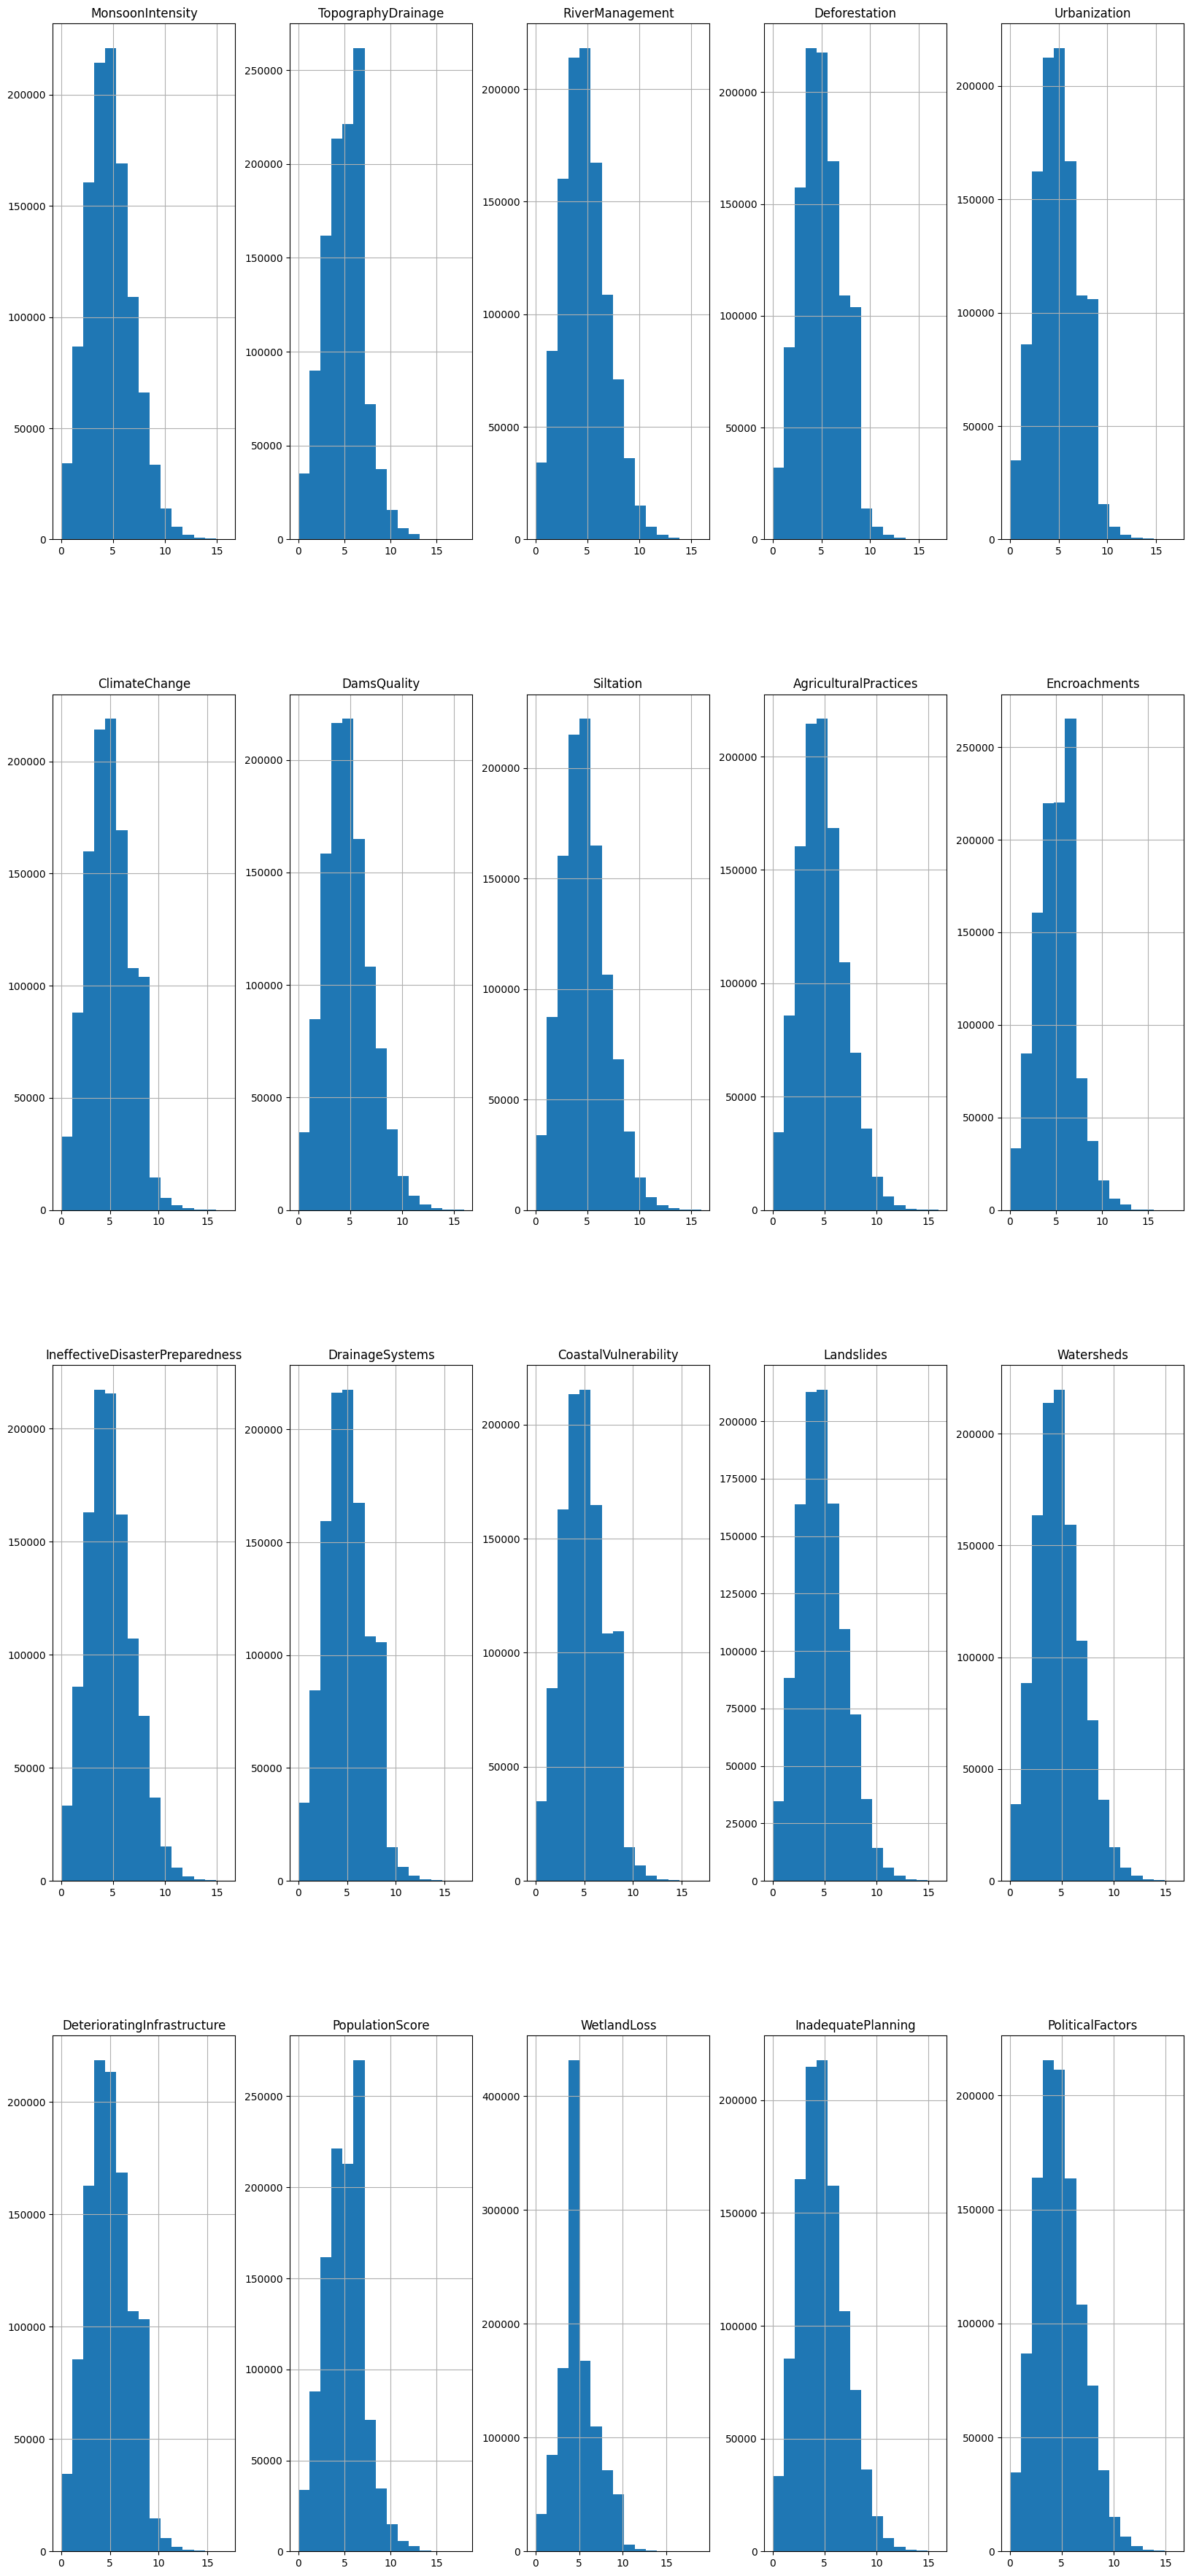

In [8]:
# Layout of data
features_train = train_data.set_index("id")
target_column = "FloodProbability"
label_train = features_train.pop(target_column)
features_train.hist(bins=15, figsize=(20, 45), layout=(4, 5))

array([[<Axes: title={'center': 'MonsoonIntensity'}>,
        <Axes: title={'center': 'TopographyDrainage'}>,
        <Axes: title={'center': 'RiverManagement'}>,
        <Axes: title={'center': 'Deforestation'}>,
        <Axes: title={'center': 'Urbanization'}>],
       [<Axes: title={'center': 'ClimateChange'}>,
        <Axes: title={'center': 'DamsQuality'}>,
        <Axes: title={'center': 'Siltation'}>,
        <Axes: title={'center': 'AgriculturalPractices'}>,
        <Axes: title={'center': 'Encroachments'}>],
       [<Axes: title={'center': 'IneffectiveDisasterPreparedness'}>,
        <Axes: title={'center': 'DrainageSystems'}>,
        <Axes: title={'center': 'CoastalVulnerability'}>,
        <Axes: title={'center': 'Landslides'}>,
        <Axes: title={'center': 'Watersheds'}>],
       [<Axes: title={'center': 'DeterioratingInfrastructure'}>,
        <Axes: title={'center': 'PopulationScore'}>,
        <Axes: title={'center': 'WetlandLoss'}>,
        <Axes: title={'center': '

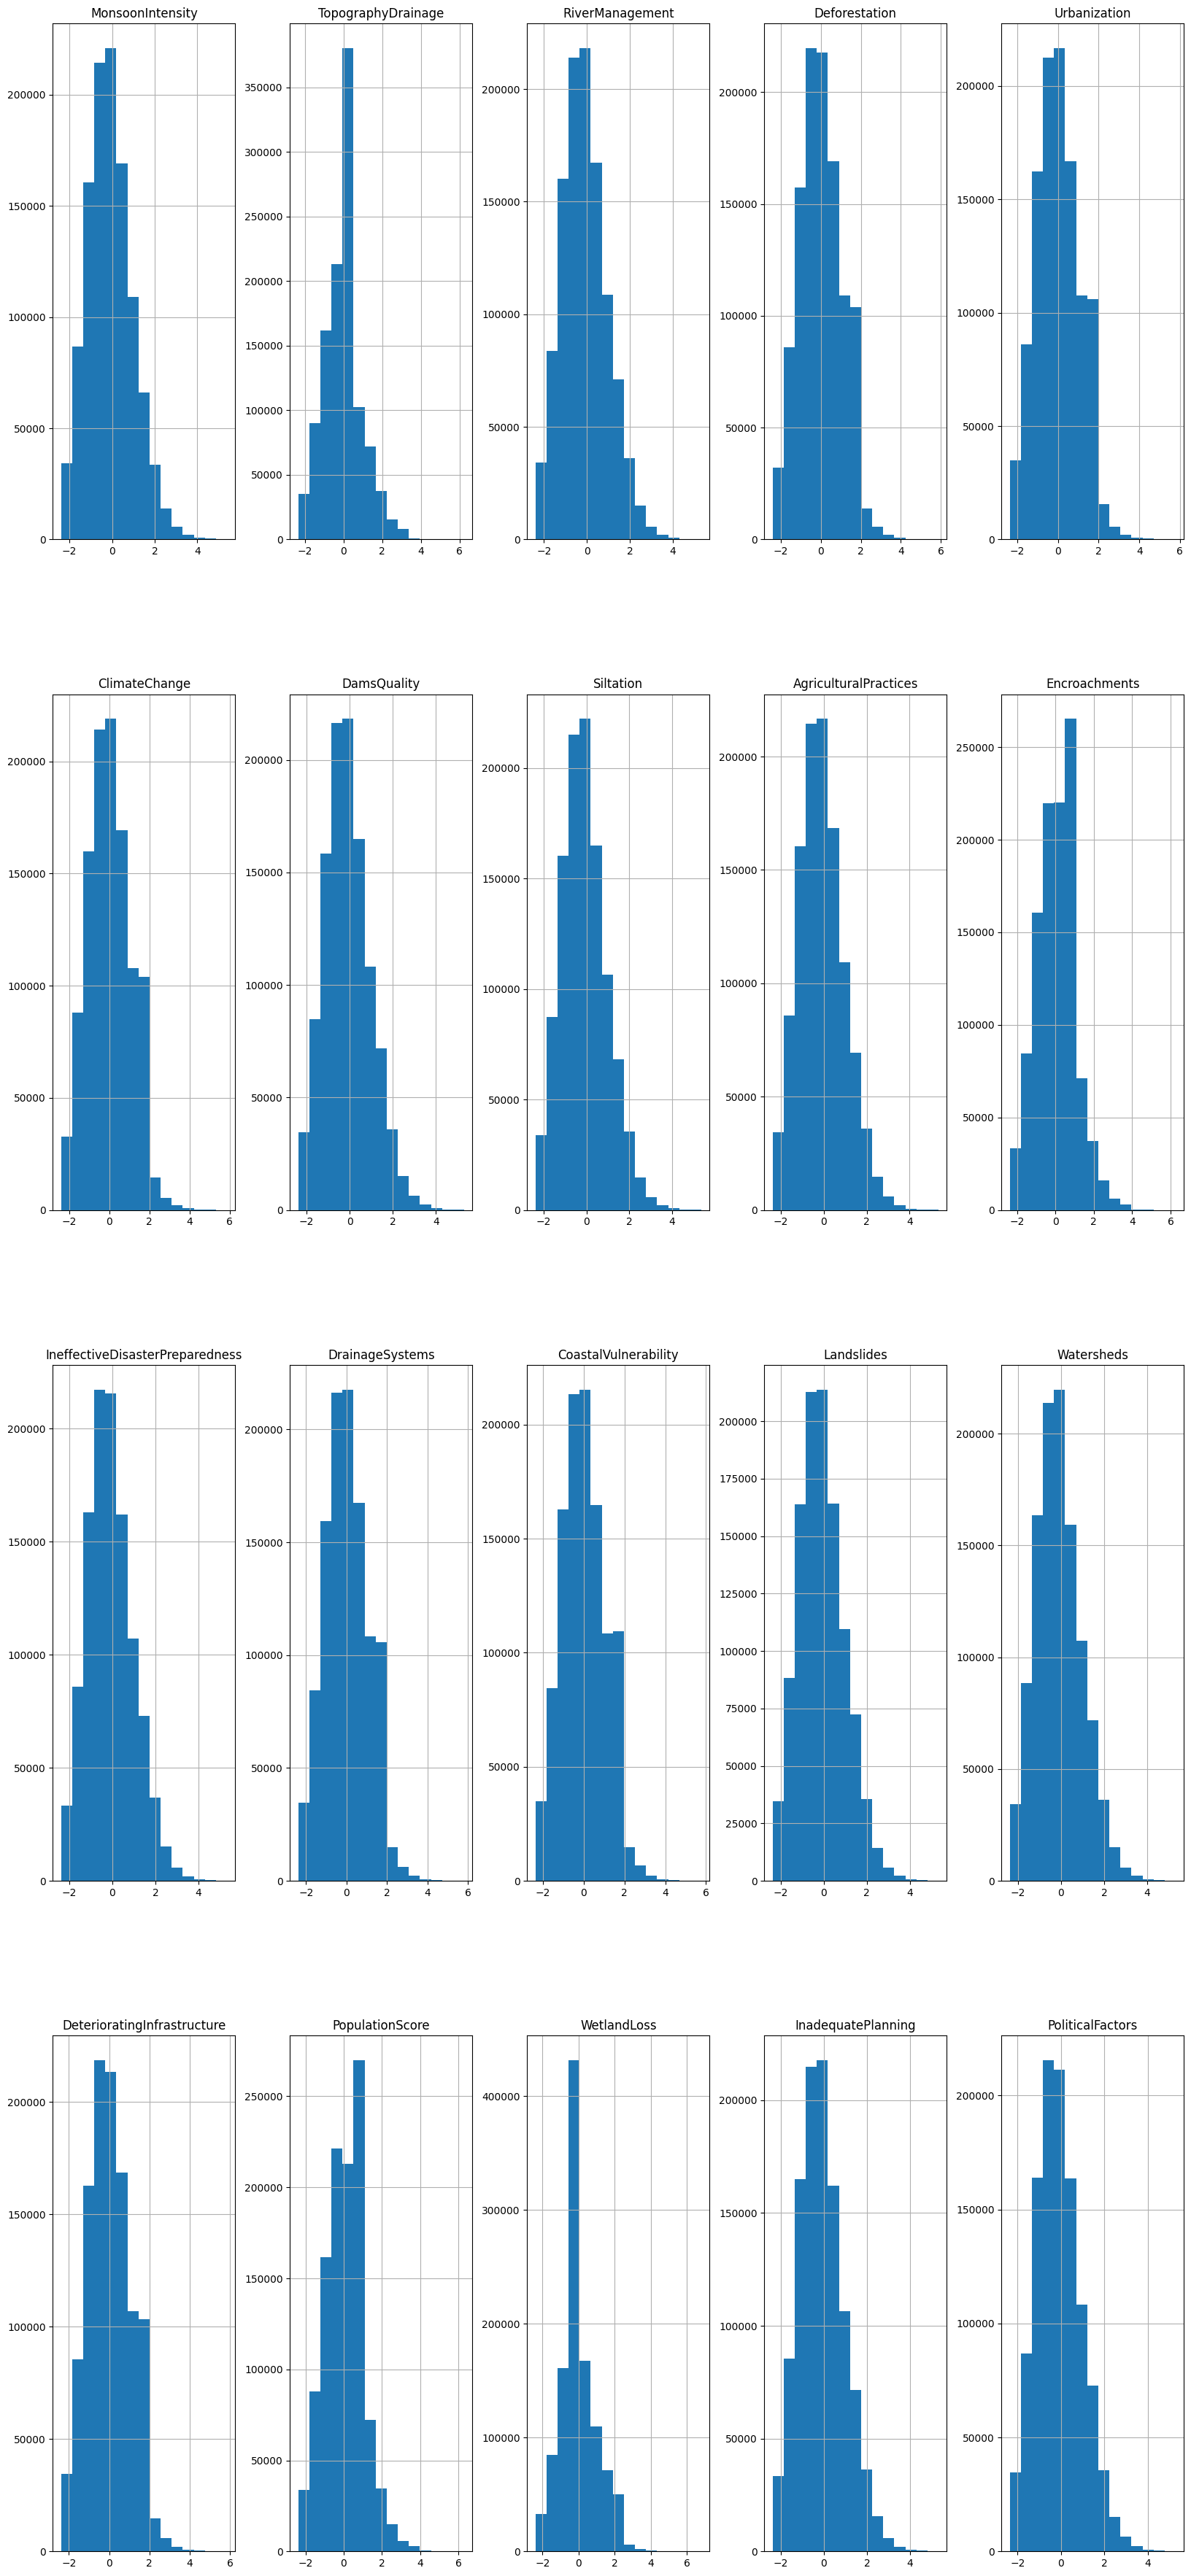

In [9]:
# Standardizing data

def standardize(data):
    standard_scaler = StandardScaler()
    standard_scaler.fit(data)
    return standard_scaler.transform(data)
    # _data = data.copy(deep=True)
    # return (_data - _data.mean(axis=0)) / _data.std(axis=0)


features_train_standardized = pd.DataFrame(standardize(features_train), columns=features_train.columns)
features_train_standardized.hist(bins=15, figsize=(20, 45), layout=(4, 5))
# print(features_train_standardized.shape)

array([[<Axes: title={'center': 'FloodProbability'}>]], dtype=object)

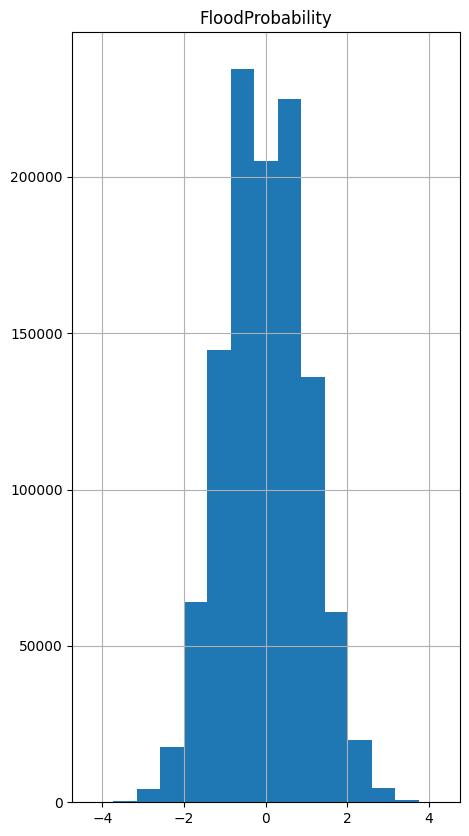

In [10]:
def standardize_labels(label_data):
    mean, std = label_data.mean(), label_data.std()
    return label_data.apply(lambda v: (v - mean) / std)


label_train_standardized = pd.DataFrame(standardize_labels(label_train), columns=[target_column])
label_train_standardized.hist(bins=15, figsize=(5, 10))

#### Train test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(features_train_standardized, label_train_standardized, test_size=0.25)

In [12]:
X_train.columns

Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors'],
      dtype='object')

#### Correlation matrix of training features

<Axes: >

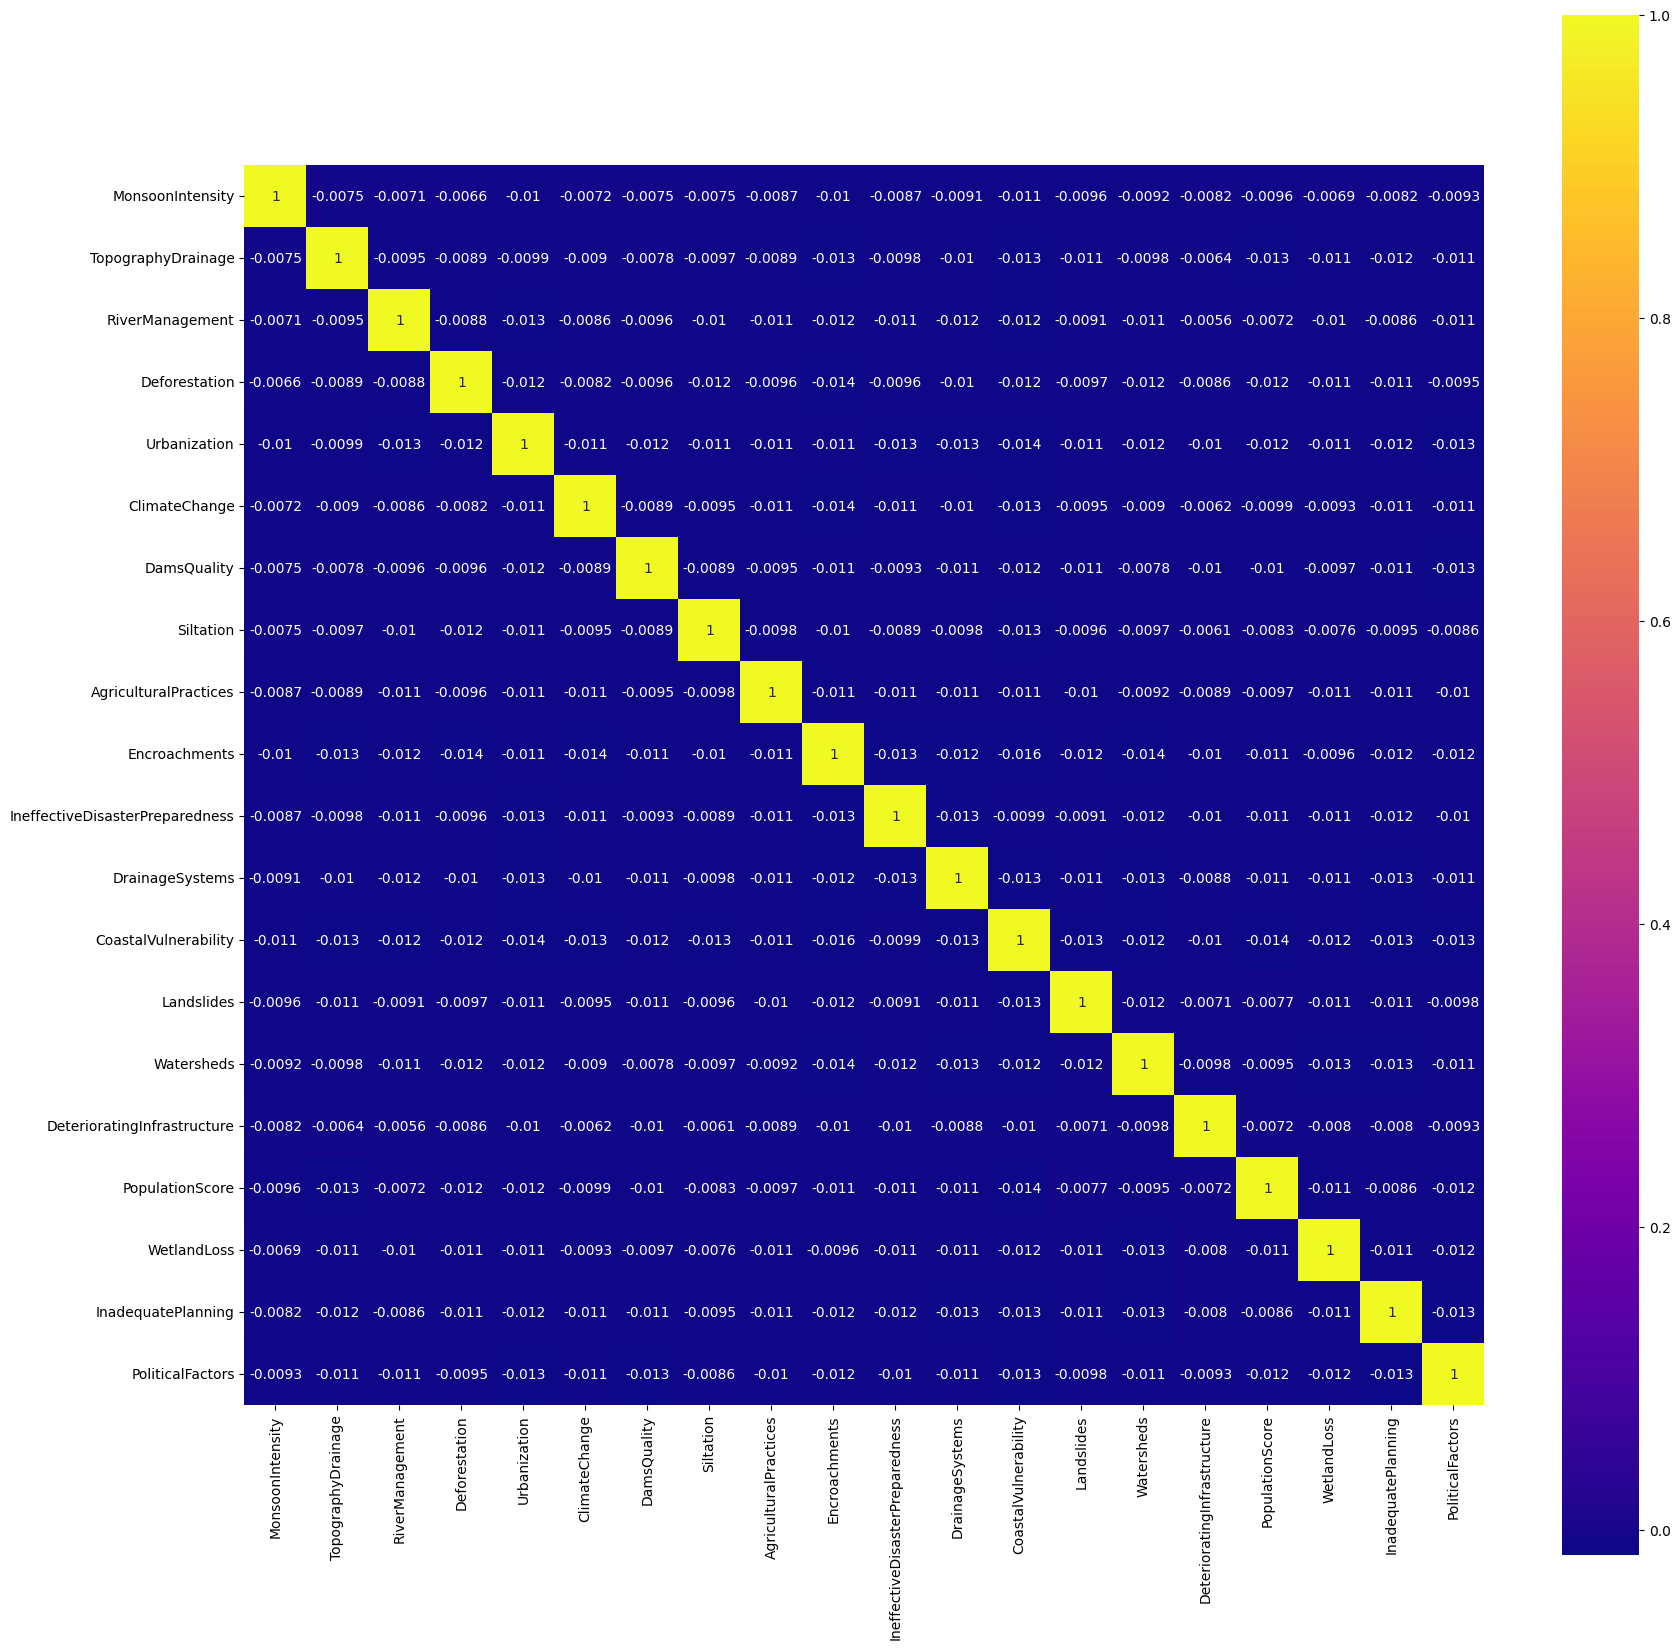

In [13]:
plt.figure(figsize=(20, 20))
sns.heatmap(X_train.corr(), vmax=1, square=True, annot=True, cmap="plasma")

### Feature Analyses


-----------------------------------
PCA Loadings 
-----------------------------------

                                      PC1       PC2       PC3       PC4  \
MonsoonIntensity                 0.046063  0.120280 -0.087206 -0.056555   
TopographyDrainage               0.234318  0.095010 -0.342118 -0.052759   
RiverManagement                 -0.126880  0.342101  0.167883  0.107587   
Deforestation                    0.302222  0.334567  0.007383 -0.365997   
Urbanization                    -0.094552 -0.212589 -0.401757 -0.048444   
ClimateChange                    0.063328  0.382381 -0.141106 -0.008760   
DamsQuality                      0.134711 -0.015991 -0.278861  0.341576   
Siltation                       -0.180148 -0.124290  0.022735  0.006997   
AgriculturalPractices            0.113946 -0.124087 -0.150536  0.069476   
Encroachments                   -0.448799 -0.423384 -0.172198 -0.086885   
IneffectiveDisasterPreparedness  0.246062 -0.240701  0.289681 -0.060560   
DrainageSyst

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



-----------------------------------
Mutual Information Scores 
-----------------------------------

Siltation                          0.021242
DeterioratingInfrastructure        0.020897
TopographyDrainage                 0.020770
DamsQuality                        0.020560
Watersheds                         0.020497
PopulationScore                    0.020075
InadequatePlanning                 0.019699
ClimateChange                      0.019618
RiverManagement                    0.019313
Deforestation                      0.019171
WetlandLoss                        0.019130
Landslides                         0.019127
AgriculturalPractices              0.019044
MonsoonIntensity                   0.018915
IneffectiveDisasterPreparedness    0.018874
DrainageSystems                    0.017990
PoliticalFactors                   0.017907
Encroachments                      0.017895
Urbanization                       0.017562
CoastalVulnerability               0.017412
Name: Mutual Info S

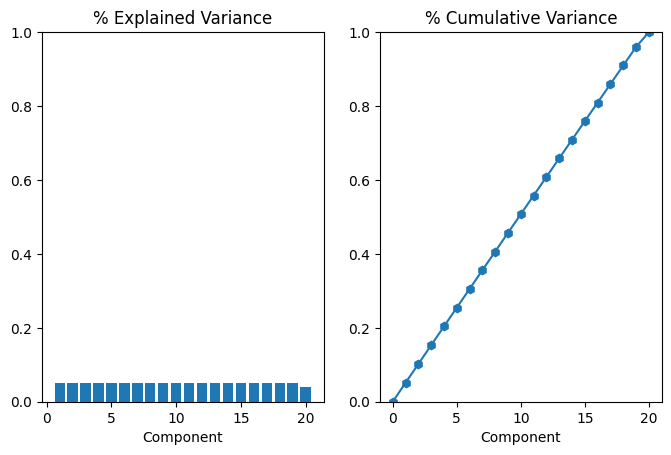

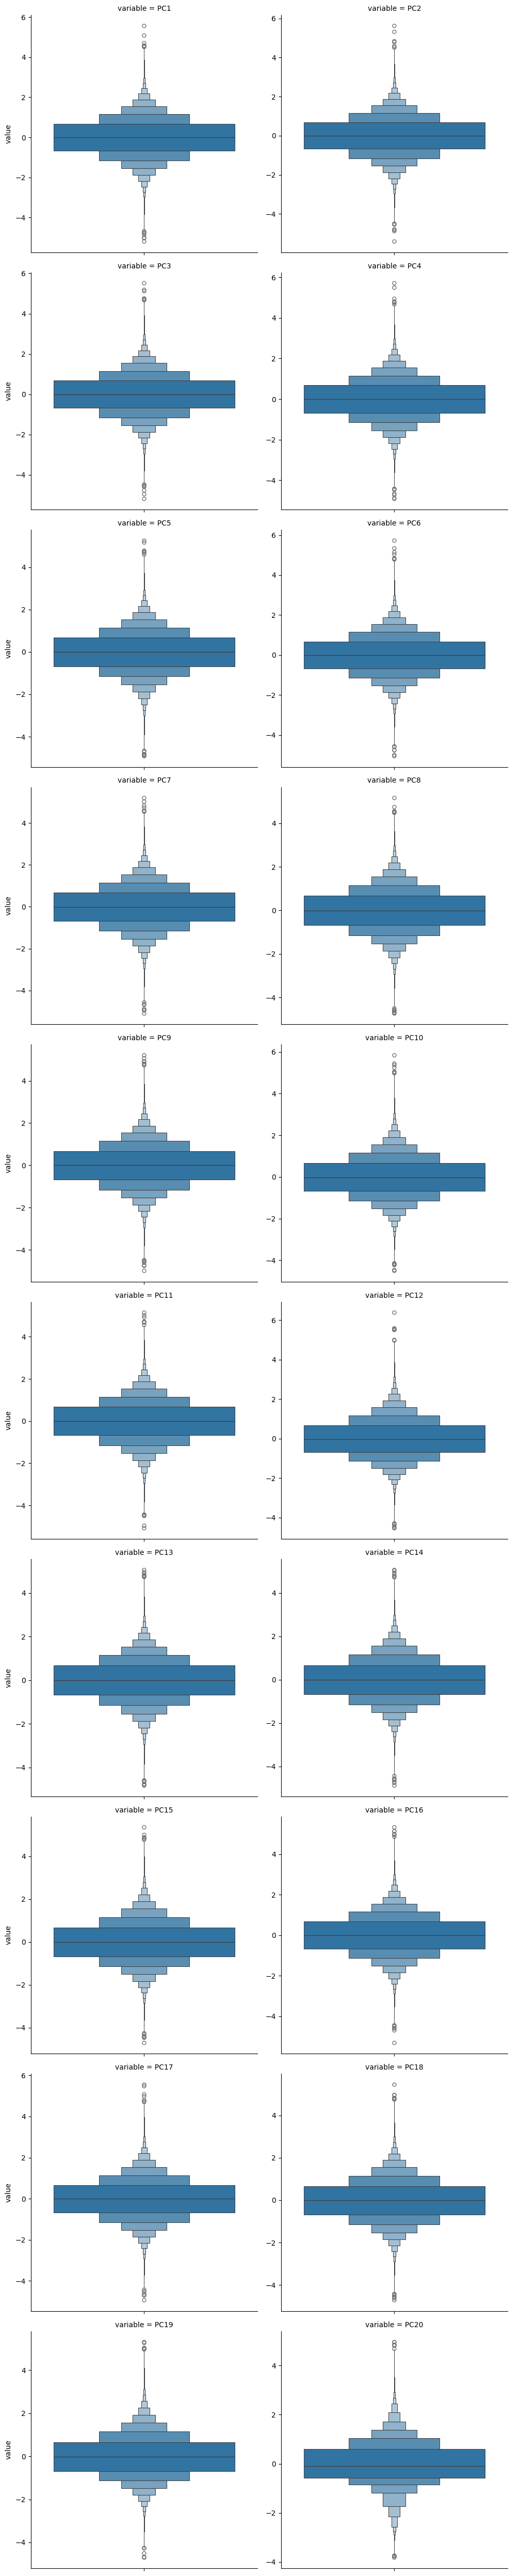

In [14]:
class FeatureAnalyzer:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.pca = PCA()
        self.pca.fit_transform(self.X)

    @property
    def X_pca(self):
        x_pca = self.pca.fit_transform(self.X)
        return pd.DataFrame(x_pca, columns=[f"PC{i+1}" for i in range(x_pca.shape[1])])

    @property
    def pca_loadings(self):
        return pd.DataFrame(self.pca.components_.T, columns=self.X_pca.columns, index=self.X.columns)

    def plot_variance(self, width=8, dpi=100):
        fig, axes = plt.subplots(1, 2)
        n = self.pca.n_components_
        print(f"\n{'-' * 35}\nPCA Loadings \n{'-' * 35}\n")
        print(self.pca_loadings)
        grid = np.arange(1, n+1)
        explained_variance = self.pca.explained_variance_ratio_
        axes[0].bar(grid, explained_variance)
        axes[0].set(xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0))
        cumulative_variance = np.cumsum(explained_variance)
        axes[1].plot(np.r_[0, grid], np.r_[0, cumulative_variance], marker="h")
        axes[1].set(xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0))
        fig.set(figwidth=width, dpi=dpi)
        return axes

    def make_mi_scores(self, discrete_features: bool = False):
        mi_regression = mutual_info_regression(self.X, self.y, discrete_features=discrete_features)
        return pd.Series(mi_regression, name="Mutual Info Scores", index=self.X.columns).sort_values(ascending=False)

    def check_outliers(self):
        sns.catplot(
            y="value",
            col="variable",
            data=self.X_pca.melt(),
            kind="boxen",
            sharey=False,
            col_wrap=2
        )


def show_feature_analysis_artifacts(X, y):
    feature_analyzer = FeatureAnalyzer(X, y)
    feature_analyzer.plot_variance()
    mi_scores = feature_analyzer.make_mi_scores()
    feature_analyzer.check_outliers()
    print(f"\n{'-' * 35}\nMutual Information Scores \n{'-' * 35}\n")
    print(mi_scores)
    return feature_analyzer


feature_analyzer_object = show_feature_analysis_artifacts(X_train, y_train)

In [15]:
feature_analyzer_object.pca_loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
MonsoonIntensity,0.046063,0.120280,-0.087206,-0.056555,0.244814,-0.053163,-0.155009,-0.125310,-0.083071,-0.178723,-0.020730,0.092877,-0.303740,-0.090184,-0.342831,-0.140270,0.563881,0.348965,0.332484,0.185296
TopographyDrainage,0.234318,0.095010,-0.342118,-0.052759,0.123568,0.007620,-0.052097,0.207854,-0.090367,0.637369,0.077292,0.019754,-0.068815,-0.078031,-0.175333,0.131911,-0.156396,0.337757,-0.300458,0.215510
RiverManagement,-0.126880,0.342101,0.167883,0.107587,0.083751,-0.058413,0.020055,0.004181,0.007077,0.135189,0.441151,-0.180710,-0.362840,-0.049881,-0.015757,-0.288342,0.119567,-0.479542,-0.252352,0.212595
Deforestation,0.302222,0.334567,0.007383,-0.365997,0.172684,-0.227196,0.147586,-0.309120,0.063072,-0.186639,0.012826,-0.010391,-0.057236,-0.029704,0.503845,0.329686,-0.020180,0.067263,-0.074953,0.218170
Urbanization,-0.094552,-0.212589,-0.401757,-0.048444,0.011206,-0.275292,0.475083,0.428322,-0.040495,-0.177503,-0.249885,-0.204688,-0.212138,-0.052062,0.089967,-0.135864,-0.019192,-0.122475,0.094000,0.247140
ClimateChange,0.063328,0.382381,-0.141106,-0.008760,0.016471,0.106351,-0.092681,0.283633,-0.009334,-0.350916,0.045905,0.010214,0.444092,0.472499,-0.058223,-0.281187,0.003548,0.120229,-0.203250,0.212178
DamsQuality,0.134711,-0.015991,-0.278861,0.341576,0.105676,-0.133106,-0.313419,-0.187401,0.345440,0.017854,0.011614,0.052343,0.177055,-0.316946,0.212336,-0.370036,-0.269981,-0.043554,0.262065,0.212417
Siltation,-0.180148,-0.124290,0.022735,0.006997,-0.077846,0.181111,-0.403849,0.090132,-0.369792,0.054348,-0.334547,0.017848,0.001974,-0.175518,0.486024,-0.087183,0.310457,-0.021440,-0.277971,0.201921
AgriculturalPractices,0.113946,-0.124087,-0.150536,0.069476,-0.186741,0.133414,0.334965,-0.326771,-0.124845,0.158143,-0.024737,0.654145,-0.048630,0.281038,0.038327,-0.171284,0.085392,-0.191738,-0.002709,0.217138
Encroachments,-0.448799,-0.423384,-0.172198,-0.086885,0.100591,-0.085868,0.004716,-0.234582,0.151036,0.065085,0.433906,-0.177810,0.261089,0.196189,0.075177,0.150080,0.201751,0.135415,-0.062790,0.254610


#### Visualize principal components

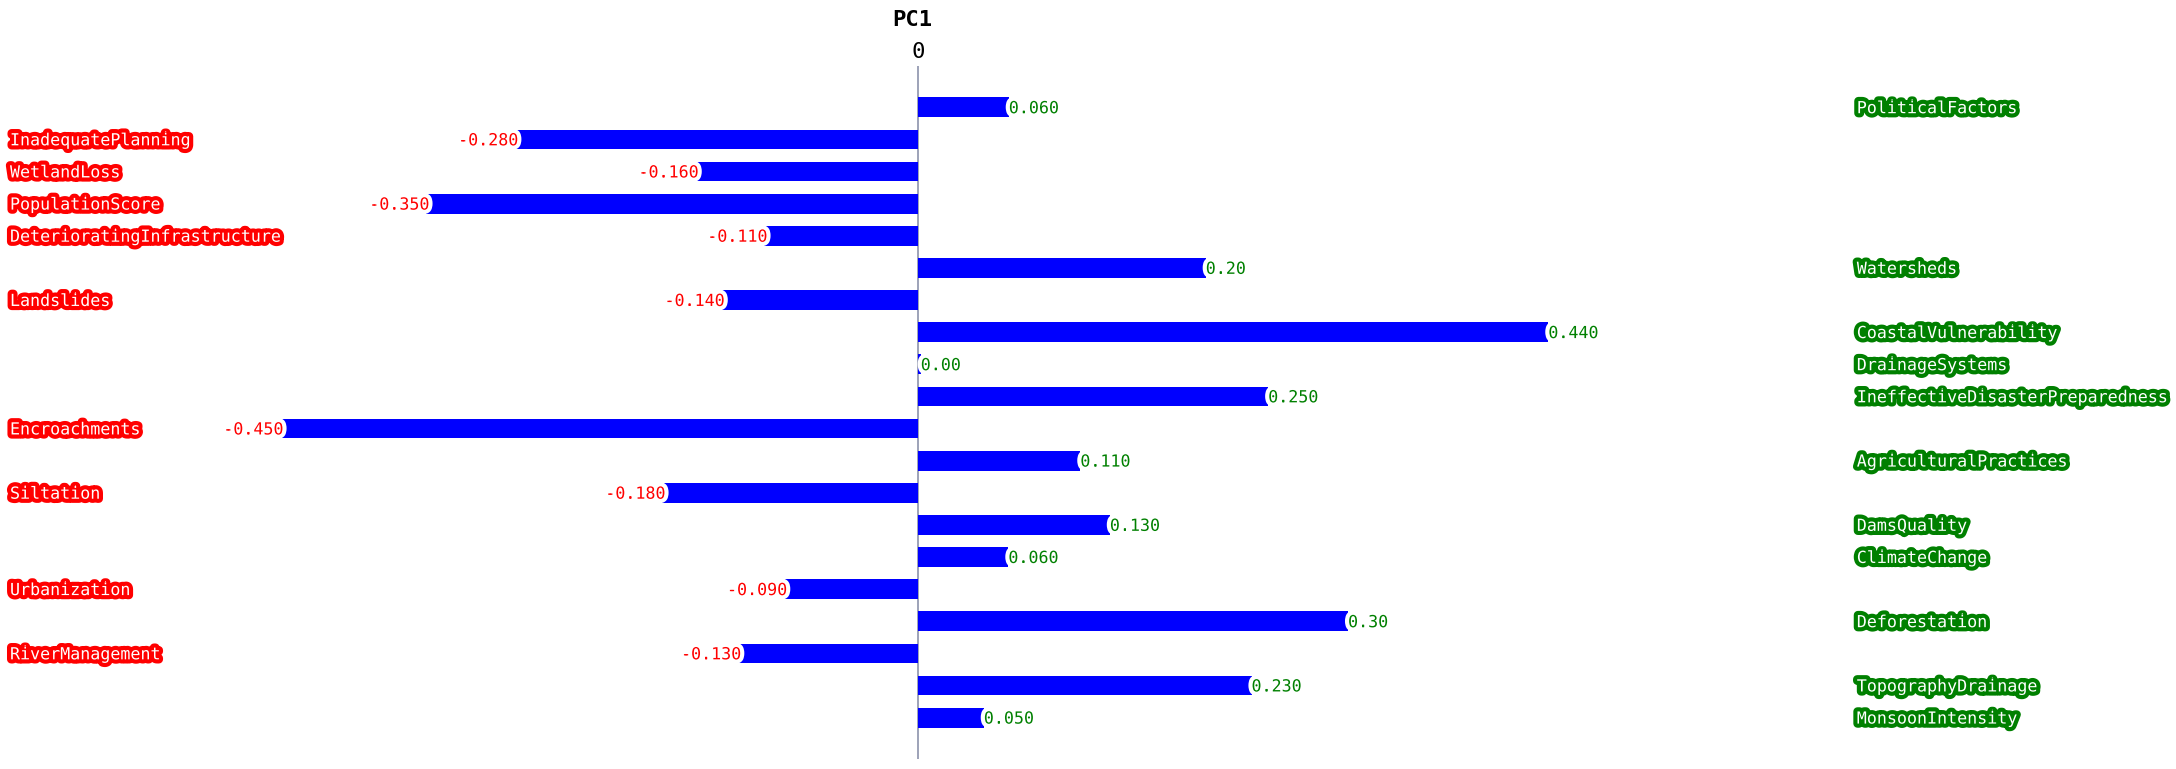

In [24]:
def plot_principal_component(feature_analyzer_object, level=1):
    if level < 1:
        raise ValueError("PC level can't be less than 1")
    _loadings = feature_analyzer_object.pca_loadings
    _column = _loadings.columns[level - 1]
    pc_dataframe = _loadings.loc[:, _column].reset_index().to_dict(orient="records")
    feature_to_pc1 = {_entry["index"]: float(_entry[_column]) for _entry in pc_dataframe}
    chart = Charts(data=feature_to_pc1, font_family="monospace")
    chart.plot(title=_column)

plot_principal_component(feature_analyzer_object, level=1)

#### Adding new features [test]

In [25]:
X_train_new = X_train.copy(deep=True)
X_train_new["IsCoastalVulnerability"] = X_train["CoastalVulnerability"] > 0
X_train_new["IsIneffectiveDisasterPreparedness"] = X_train["IneffectiveDisasterPreparedness"] > 0
X_train_new["IsDeforestation"] = X_train["Deforestation"] > 0
X_test_new = X_test.copy(deep=True)
X_test_new["IsCoastalVulnerability"] = X_test["CoastalVulnerability"] > 0
X_test_new["IsIneffectiveDisasterPreparedness"] = X_test["IneffectiveDisasterPreparedness"] > 0
X_test_new["IsDeforestation"] = X_test["Deforestation"] > 0

## **Training the model**

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor


class RegressionModel:
    def __init__(
        self,
        train_data,
        test_data,
        learning_rate=0.01,
        n_estimators=1000,
        early_stopping_rounds=5,
        n_jobs=1
    ):
        self.model = XGBRegressor()